In [2]:
from __future__ import print_function
import os
import sys
import numpy as np
import io
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import numpy as np
import pandas as pd
import os, cv2

## download the melanoma model using urllib,uncomment the below
"""
import urllib
# download .h5 model weight from Azure fileshare using Shared Access Signature (SAS) 
#urllib.request.urlretrieve('get_SAS_token_from_fileshare', filename = './skin_lesion.h5')
"""

#custom to us are the labels and the image size
LABELS = ['melanoma', 'notmelanoma']

    #I originally tried 200 * 200 and gave me an error - this is because the input layer is a 32 neuron so we need multiples of 32
#I'm going to use 32*7 = 224

IMAGE_H, IMAGE_W = 192, 192
#Grids are used when you are facing problems with more than one object to detect and the fact they alow 2 (in the original)
#overlapping bouding boxes. In our case, we have only 1 very well defined object to detect so we don't need more than 1 grid 

#GRID_H,  GRID_W  = 7 , 7

#Let's leave the rest as is

BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

lesionYN={1:'melanoma',0:'no_melanoma'}

### modified from :https://github.com/ibrahimokdadov/upload_file_python/tree/master/src
##### model loading methods
    
def network():
    model = load_model()
    model.load_weights('./skin_lesion.h5')
    return model
    
def load_model():
    #make model global
    global model
    ######## build the model and load the pre-trained weights  
    ### building the network
    # the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
    def space_to_depth_x2(x):
        return tf.space_to_depth(x, block_size=2)
    input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
    #true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

    #NOTE ON THE SINTAX = This isn't using Sequential(), it's building a pipeline of layers applied to
    #the input_image. So what this is doing x = fn...(f1(x)). Nested functions. This is very useful when you need to do skip
    #connections or you need to do something a bit more complex to the output, it isn't a clear sequence

    # Layer 1
    x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
    x = BatchNormalization(name='norm_1')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 2
    x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
    x = BatchNormalization(name='norm_2')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 3
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
    x = BatchNormalization(name='norm_3')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 4
    x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
    x = BatchNormalization(name='norm_4')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 5
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
    x = BatchNormalization(name='norm_5')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 6
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
    x = BatchNormalization(name='norm_6')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 7
    x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
    x = BatchNormalization(name='norm_7')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 8
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
    x = BatchNormalization(name='norm_8')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 9
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
    x = BatchNormalization(name='norm_9')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 10
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
    x = BatchNormalization(name='norm_10')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 11
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
    x = BatchNormalization(name='norm_11')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 12
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
    x = BatchNormalization(name='norm_12')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 13
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
    x = BatchNormalization(name='norm_13')(x)
    x = LeakyReLU(alpha=0.1)(x)

    skip_connection = x

    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 14
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
    x = BatchNormalization(name='norm_14')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 15
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
    x = BatchNormalization(name='norm_15')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 16
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
    x = BatchNormalization(name='norm_16')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 17
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
    x = BatchNormalization(name='norm_17')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 18
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
    x = BatchNormalization(name='norm_18')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 19
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
    x = BatchNormalization(name='norm_19')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 20
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
    x = BatchNormalization(name='norm_20')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 21
    skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
    skip_connection = BatchNormalization(name='norm_21')(skip_connection)
    skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
    skip_connection = Lambda(space_to_depth_x2)(skip_connection)

    x = concatenate([skip_connection, x])

    # Layer 22
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
    x = BatchNormalization(name='norm_22')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # As per the comment below, we only need 4 outputs so we are adding a dense layer as an output with one neuron per dimension
    #Important - the output of layer22 is a 6*6 feature map with 1024 feature maps so 6*6*1024 - This is not really what we need
    #Therefore we need to flatten the output so we can apply the final transforamtion in the dense and get the output we nee
    #output.shape(none, 4) 
    #none = the number of batches if we were splitting our dataset in batches


    x = Flatten()(x)
    x = Dropout(0.5)(x)
    #We are now adding classification so you need two different activation functions - one linear for the bounding box
    # and a sigmoid for the classification problem
    output_box = Dense(4, activation='linear', name='output_box')(x)
    output_class = Dense(1, activation ='sigmoid', name='output_class')(x)
    output = [output_box, output_class]
    # Layer 23
    #What they are doing here is to recreante a dense layer using a convolusion but they are just fixing the weights for each feature
    #map but reading each pixel at a time with those same weights in each feature map
    #What we want is to adapt this layer to the number of outputs we want. In our case - xmin, ymin, xmax, ymax
    #x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    #output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)
    # small hack to allow true_boxes to be registered when Keras build the model 
    # for more information: https://github.com/fchollet/keras/issues/2790
    #output = Lambda(lambda args: args[0])([output, true_boxes])
    model = Model(input_image, output)
    #This parameters where originally in the model we took
    optimizer = Adam(lr=0.001)
    #Try Adam, Adamax with default parameters but the lr
    #optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #optimizer = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
    #optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

    loss = {'output_box': 'mse',
            'output_class': 'binary_crossentropy'
           }

    metrics = {'output_box': ['mae'],
            'output_class': ['accuracy']
           }
    alpha = K.variable(0.7)
    beta = K.variable(0.3)
    #From looking at the results we might need to give the loss different weights as the classification is slowing down the learning
    #loss_weights as a parameter
    model.compile(loss=loss,loss_weights=[alpha, beta],
                  optimizer=optimizer,
                  metrics=metrics)
            
    return model

def load_model_here():
    global model
    #make model global
    #path = Model.get_model_path('visualsearch.h5')
    #model=load_model(path)
    try:
        model=network()
        model.load_weights('./skin_lesion.h5')
        #define graf othervise does not work with flask 
        #graph = tf.get_default_graph()
    except:
        del model
        keras.backend.clear_session()
        model=load_model()
        model.load_weights('./skin_lesion.h5')
        #graph = tf.get_default_graph()
    return model


model=load_model_here()
model.summary()


Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 192, 192, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 192, 192, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 192, 192, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

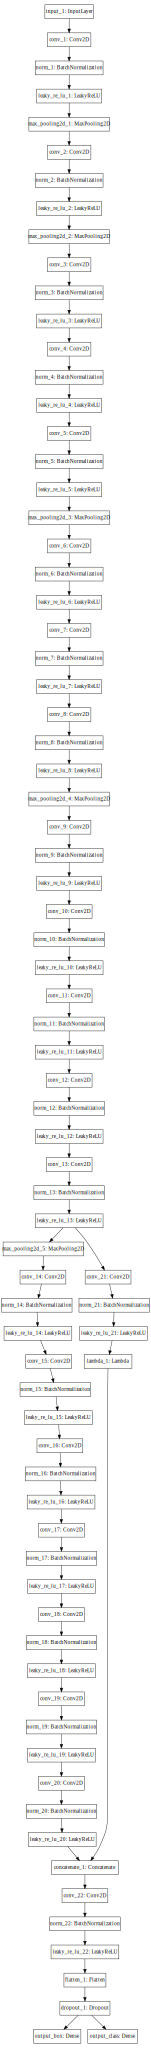

In [50]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FormatStrFormatter
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)

# save the model graph to png
from keras.utils import plot_model
plot_model(model, to_file='model.png')
# visualize the model
SVG(model_to_dot(model, show_shapes=False)
    .create(prog='dot', format='svg'))


In [29]:
# with a Sequential model
path='C:/Users/zecharpy/Desktop/MLapi/Melanoma/'
im1=cv2.imread(path+'melanoma.jpg')
im2=cv2.imread(path+'healthy.jpg')

def read_preprocessing(img):
    
    img = cv2.resize(img,(192,192))
    print(img.shape)
    img=img/255
    img_feed=img.reshape(1,IMAGE_H,IMAGE_W,3)
    return img , img_feed
im1,im1_feed=read_preprocessing(im1)
im2,im2_feed=read_preprocessing(im2)
        
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[-7].output])
layer_output_lesion = get_3rd_layer_output([im1_feed])[0]
layer_output_healthy = get_3rd_layer_output([im2_feed])[0]
out1=model.predict(im1_feed)
out2=model.predict(im2_feed)

pred1=out1[1][0][0]
pred2=out2[1][0][0]

def cancerYN(prob):
    if prob>0.6 :
        return 'skin lesion'
    else:
        return 'healthy'

layer_output_lesion.shape,layer_output_healthy.shape ,out1[0].shape, pred1, pred2

(192, 192, 3)
(192, 192, 3)


((1, 6, 6, 1024), (1, 6, 6, 1024), (1, 4), 0.99445844, 0.55097848)

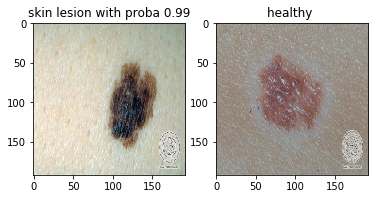

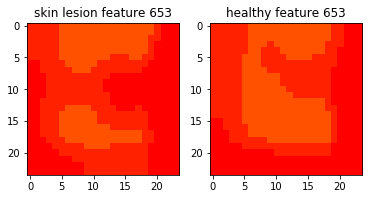

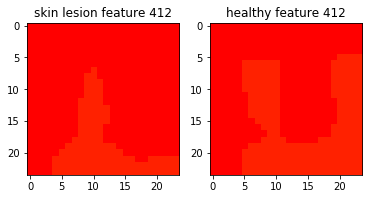

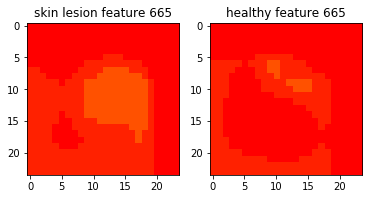

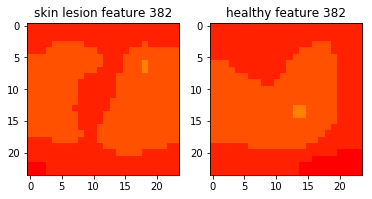

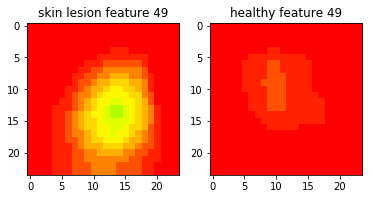

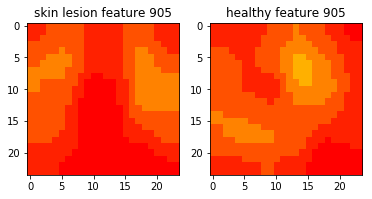

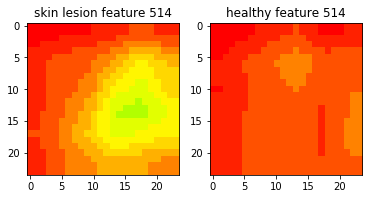

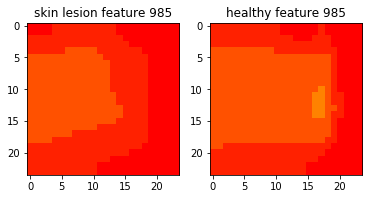

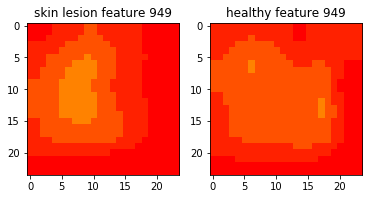

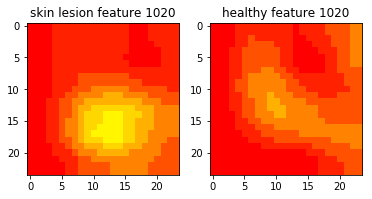

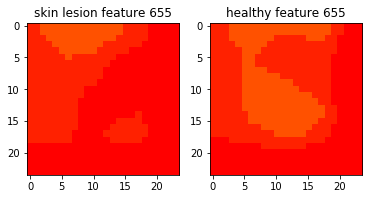

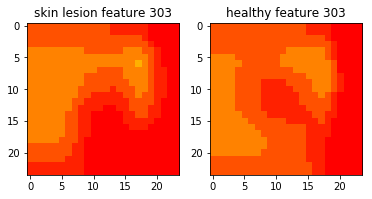

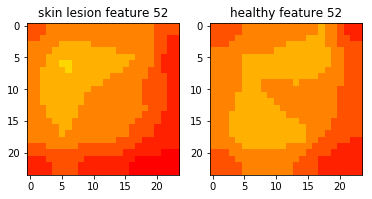

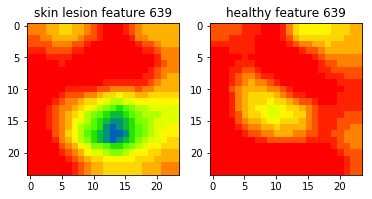

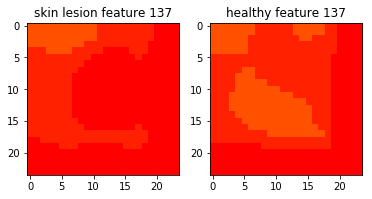

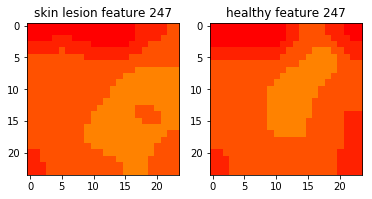

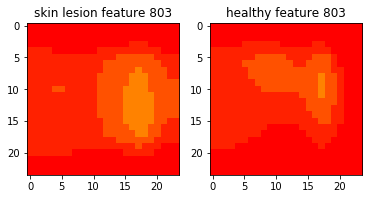

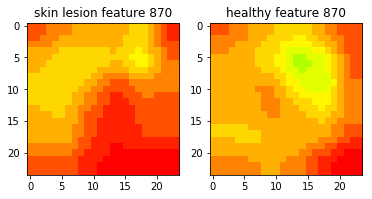

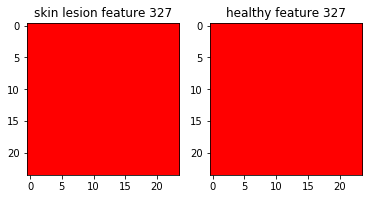

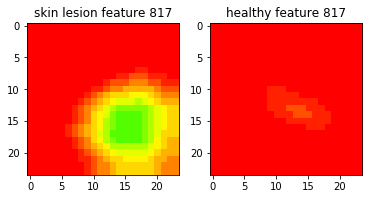

In [46]:
%matplotlib inline
# plot the original two images
import random
import matplotlib.pyplot as plt
import cv2

plt.subplot(1,2,1)
plt.imshow(im1[:,:,[2,1,0]],cmap="gray", vmin=0, vmax=255)
plt.title("{} with proba {}".format(cancerYN(pred1),str(round(pred1,2))))

plt.subplot(1,2,2)
plt.imshow(im2[:,:,[2,1,0]],cmap="gray", vmin=0, vmax=255)
plt.title("{} ".format(cancerYN(pred2)))
plt.show()
#plot the features for these two image, what the model see
for i in [random.randint(0,1024) for _ in range(20)]:
    o1=layer_output_lesion[0,:,:,i]
    o1 = cv2.resize(o1,(24,24))
    o2=layer_output_healthy[0,:,:,i]

    o2 = cv2.resize(o2,(24,24))
    plt.subplot(1,2,1)
    plt.imshow(o1, cmap='prism', vmin=0, vmax=255)
    plt.title("{} feature {}".format(cancerYN(pred1),str(i)))    
    plt.subplot(1,2,2)
    plt.imshow(o2, cmap='prism', vmin=0, vmax=255)
    plt.title("{} feature {}".format(cancerYN(pred2),str(i))) 
 
    plt.show()

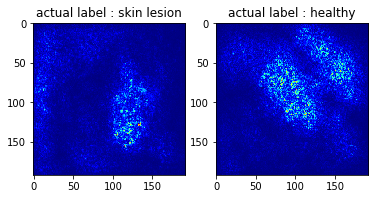

In [57]:
from keras import activations

from vis.utils import utils
from keras import activations
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations


# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'conv_22')
labels= ['skin lesion' ,'healthy']
f, ax = plt.subplots(1, 2)
cnt=0
for img in [im1,im2]:    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_saliency(model, layer_idx, filter_indices=20, seed_input=img)
    
    # visualize grads as heatmap
    ax[cnt].imshow(grads, cmap='jet')
    ax[cnt].set_title("actual label : "+labels[cnt])
    cnt+=1

In [43]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

from keras.applications import VGG16
from vis.utils import utils
from keras import activations


# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'output_class')
"""
# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)
f, ax = plt.subplots(1, 2)
plt.suptitle("left:skin lesion | right:healthy")
ax[0].imshow(im1[:,:,[2,1,0]])
ax[1].imshow(im2[:,:,[2,1,0]])


for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([im1,im2]):    
        
        grads = visualize_cam(model, layer_idx, filter_indices=0, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))
        """

'\n# Swap softmax with linear\nmodel.layers[layer_idx].activation = activations.linear\nmodel = utils.apply_modifications(model)\nf, ax = plt.subplots(1, 2)\nplt.suptitle("left:skin lesion | right:healthy")\nax[0].imshow(im1[:,:,[2,1,0]])\nax[1].imshow(im2[:,:,[2,1,0]])\n\n\nfor modifier in [None, \'guided\', \'relu\']:\n    plt.figure()\n    f, ax = plt.subplots(1, 2)\n    plt.suptitle("vanilla" if modifier is None else modifier)\n    for i, img in enumerate([im1,im2]):    \n        \n        grads = visualize_cam(model, layer_idx, filter_indices=0, \n                              seed_input=img, backprop_modifier=modifier)        \n        # Lets overlay the heatmap onto original image.    \n        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)\n        ax[i].imshow(overlay(jet_heatmap, img))\n        '